In [1]:
%matplotlib notebook

# Nutils by example

### About Nutils
Nutils is a python based finite element package. Nutils does not come with a GUI. You have to write a python script yourself. Nutils provides a set of tools help you implement a weak formulation quite easily.

Some basic understanding of python is useful. If you are unfamiliar with python you might want to browser through a tutorial.

### Einstein notation
All mathematical equations in this document are written using the Einstein Notation. All indices of vectors, matrices or higher-dimensional arrays are explicitly listed. The following special cases apply:

* Indices following a comma denote derivatives:

$$ u_{i,jk} $$

is equivalient to 

$$ \frac{\partial^2 u_i}{\partial x_j \partial x_k}.$$

* Repeated indices in a term are summed:

$$ u_{,ii} + v_j w_{,j} $$

is equivalent to 

$$ \sum_i \frac{\partial^2 u_i}{\partial^2 x_i} + \sum_j v_j \frac{\partial w}{\partial x_j}$$

## Laplace's equation with Neumann BC's

Consider the following system ([Laplace's equation](https://en.wikipedia.org/wiki/Laplace%27s_equation) with homogeneous Neumann boundary conditions):

$$ \left\{ \begin{array}{ll} - u_{,kk} = 0 & \text{in } \Omega \\ u_{,k}n_k = 0 & \text{on } \partial \Omega \end{array}\right. $$

with $n$ the outward normal and domain $\Omega=[-1/\sqrt{2}, 1/\sqrt{2}]^2$. Note that this system is singular.

Let $\varphi : \Omega \rightarrow \mathbb{R}^N$ a basis on domain $\Omega$. A weak formulation of this system reads:

> Find $w_j$ such that for all $i\in \{0,1,...,N-1\}$    $$ \int_\Omega \varphi_{i,k} \varphi_{j,k} w_j d\Omega=0$$

The solution $u$ is then approximated by $\varphi_j w_j$, i.e. the dot product of the basis $\varphi$ with vector $w$.

Let $T$ be a structured partition of $8\times 8$ equally sized elements of $\Omega$ and $\varphi$ a linear basis on 
$T$. The following Nutils script implements the weak formulation and finds a solution:



In [2]:
import numpy
from nutils import *

# construct topology, geometry and basis
verts = numpy.linspace(-0.5**0.5, 0.5**0.5, 9)
domain, geom = mesh.rectilinear([verts, verts])

# construct the namespace
ns = function.Namespace()
ns.x = geom
ns.basis = domain.basis('spline', degree=1)

# construct matrix
A = domain.integrate(
    ns.eval_ij('basis_i,k basis_j,k'),
    geometry=geom, ischeme='gauss3')

# solve linear system
w = A.solve()

solve > right hand side is zero


### Importing nutils

In this script the line

In [3]:
from nutils import *

loads the python package `nutils`. This line is mandatory for all nutils scripts. See the [python docs](https://docs.python.org/3/tutorial/modules.html#packages) for more information on importing packages.

### Topology and geometry
With the line

In [4]:
domain, geom = mesh.rectilinear([verts, verts])
print(domain.shape)
print(geom.shape)

(8, 8)
(2,)


we create a structured two-dimensional mesh. The argument `[verts, verts]` of function `mesh.rectilinear` specifies the vertices of the mesh per dimension, i.e. `verts` in the first dimension and also `verts` in the second dimension. `mesh.rectilinear([verts])` would create a one-dimensional mesh and `mesh.rectilinear([verts, verts, verts])` a three-dimensional structured mesh.

The variable `verts` contains a list of vertices, e.g. `[0, 0.25, 0.5, 0.75, 1]`. The function numpy.linspace creates a list of equally spaced numbers between two end points, e.g. `numpy.linspace(0, 1, 5)` returns `[0, 0.25, 0.5 0.75, 1]`. The first two arguments describe the two end points, the third argument the number of points. The number of elements corresponding to a list of vertices is always the number of vertices minus one.

The function `mesh.rectilinear` returns a topology and a geometry object, in the example respectively stored in variables domain and geom. The 

topology object contains information about the elements and the connectivity between the elements, but no geometric information. The geometry object is a Nutils function that connects a topological coordinate to a geometric coordinate. To illustrate the difference the following example generates the same one-dimensional topology twice, but with different geometry functions:

In [5]:
verts1 = [0, 1, 2, 3, 4]
domain1, geom1 = mesh.rectilinear([verts1])
verts2 = [0, 0.25, 0.5, 0.75, 1]
domain2, geom2 = mesh.rectilinear([verts2])

### Basis and namespace
with

In [6]:
ns = function.Namespace()
ns.x = geom
ns.basis = domain.basis('spline', degree=1)

a linear basis is created on topology domain and stored in variable basis. The first argument to `domain.basis` specifies the type of the basis, e.g. `'spline'` for a spline basis or `'discont'` for a basis suitable for discontinuous Galerking FEM. The second argument specifies the degree of the basis.

We wrap these basis into a `namespace`. A namespace is a useful way of formulating problems through expression strings. This is done by calling for instance `eval_ij` on this object which would parse the expression string and return a matrix for all indices `i` and `j`. There is a [complete documentation of the expression string syntax](http://docs.nutils.org/en/latest/library/expression.html).

The Nutils function basis, like geom, can be 'evaluated' on the topology, and returns a vector of length $N^2$, where $N$ is the number of basis functions. In the example script there are 81 basis functions, one per vertex if the basis is linear. The function attribute shape returns the shape of a function. For example `ns.basis.shape` returns (81,) and `geom.shape` (2,).

In [7]:
print(ns.basis.shape)
print(geom.shape)

(81,)
(2,)


### Numerical integration

Every topology object has an `integrate` method that can integrate an integrand (first argument) using a numerical scheme specified by the [keyword argument](https://docs.python.org/3/tutorial/controlflow.html#keyword-arguments) `ischeme` on a certain geometry specified by the keyword argument geometry. The following python code evaluates the integral

$$ A_ij = \int_\Omega \varphi_{i,k}\varphi_{j,k} d\Omega :$$

In [8]:
A = domain.integrate(
    ns.eval_ij('basis_i,k basis_j,k'),
    geometry=geom, ischeme='gauss3')

The `integrate` method generates a sparse matrix if the integrand has two dimensions, i.e. two indices. An integrand with only one index will result in a vector.

We create the integrand by calling the `ns.eval_ij`-function with an expression string argument. We may put any variables we wish into the namespace, i.e. by calling `ns.basis = domain.basis('spline', degree=1)` thus the variable `basis` is here defined by us. Underscore `_` means indexing (of matrices, vectors or tensors), except when it's preceded by a comma `,` in which case it denotes differentiation wrt the given index. This is all in accordance with the established Einstein notation. There are some special variables that are always defined, that you cannot override. These include (but are not limited to) the physical evaluation point `x` and the normal vector `n`.

The shape of the sparse matrix A is equal to the shape of the integrand.

In [9]:
print(A.shape)
print(ns.eval_ij('basis_i,k basis_j,k').shape)

(81, 81)
(81, 81)


### Matrices

A sparse matrix has a `solve` method that solves linear problems of the form $A x = b$, where $A$ is the sparse matrix and $b$ is the right hand side. Passing the right hand side as the first argument to solve, e.g. `A.solve(b)` yields the solution $x$. By default a sparse direct solver is used to solve the linear system. If the keyword argument `tol` is supplied, e.g. `A.solve(b, tol=1e-8)` the linear system is solved using GMRES. If the keyword argument `symmetric=True` is supplied, the linear system is solved using CG. Note that it is your responsibility to ensure the matrix is symmetric positive definite. If the keyword argument `precon='spilu'` is supplied the iterative solver is preconditioned with ILU. By omitting the first (positional) argument the right hand side is assumed to be zero.

Instead of using Nutils' sparse matrix class, you can extract a [scipy sparse](http://docs.scipy.org/doc/scipy-0.14.0/reference/sparse.html) matrix object by calling the matrix method `toscipy()`:

In [10]:
B = A.toscipy()
type(B)

scipy.sparse.csr.csr_matrix

## Laplace's equation with Dirichlet BC's

We replace the homogeneous Neumann boundary conditions with Dirichlet boundary conditions:


$$ \left\{ \begin{array}{ll} - u_{,kk} = 0 & \text{in } \Omega \\ u = f & \text{on } \partial \Omega \end{array}\right. $$

with $f$ given by

$$ f(x) = sin(x_0) exp(x_1) $$

This system is not singular. Note that the solution to this problem is $u=f$. 

A weak formulation of this system reads

> Find $w_j$ such that for all $i\in \{0,1,...,N-1\}$ for which $\varphi_i$ as *no* support on the boundary $\partial \Omega$ 
> $$ \int_\Omega \varphi_{i,k} \varphi_{j,k} w_j d\Omega=0$$ 
> and such that for all $i\in \{0,1,...,N-1\}$ for which $\varphi_i$ *has* support on the boundary $\partial \Omega$
> $$\int_{\partial \Omega}\varphi_i\left(\varphi_j w_j - f\right) d\Omega = 0.$$

The solution $u$ is again approximated by $\varphi_jw_j$. Note that the equation above is an $L_2-$ projection of $f$ onto basis $\varphi_i$ limited to the boudnary $\partial \Omega$.

Again, let $T$ be a structured partition of $8\times 8$ equally sized elements of $\Omega$ and $\varphi$ a linear basis on $T$. The following Nutils script implements the weak formulation and finds a solution:

In [11]:
import numpy
from nutils import *

# construct topology, geometry and basis
verts = numpy.linspace(-0.5**0.5, 0.5**0.5, 9)
domain, geom = mesh.rectilinear([verts, verts])

# construct namespace
ns = function.Namespace()
ns.x = geom
ns.basis = domain.basis('spline', degree=1)

# construct matrix
A = domain.integrate(
    ns.eval_ij('basis_i,k basis_j,k'),
    geometry=geom, ischeme='gauss3')

x0,x1 = geom
f = function.sin(x0) * function.exp(x1)

# construct dirichlet boundary constraints
cons = domain.boundary.project(f, onto=ns.basis, geometry=geom, ischeme='gauss3')

# solve linear system
w = A.solve(constrain=cons)

project > solve > solving system using sparse direct solver
project > constrained 32/81 dofs, error 2.75e-04/area
solve > solving system using sparse direct solver


### Dirichlet constraints

We explain the differences with the previous script. We create a function `f` by calling `function.sin` on the first component of the two-dimensional geometry and `function.exp` on the second component:

In [12]:
x0, x1 = geom
ns.f = function.sin(x0) * function.exp(x1)

The statement `x0, x1 = geom` unpacks the two components of the function `geom`.

The dirichlet constraint is applied in the following two statements:

In [13]:
cons = domain.boundary.project(
    ns.f, onto=ns.basis, geometry=geom, ischeme='gauss3')
w = A.solve(constrain=cons)

project > solve > solving system using sparse direct solver
project > constrained 32/81 dofs, error 2.75e-04/area
solve > solving system using sparse direct solver


actually another topology object, which supports the integrate and project methods. The result vector cons contains values for all basis functions that have support on domain.boundary, otherwise float('nan').

The method solve of a Nutils matrix supports an additional keyword argument constrain. If supplied, all values, i.e. those that are not float('nan'), are copied to the solution vector and the remainder is solved.

To illustrate what happens, consider the linear system $A_{ij}x_j = b_j$ and let $i_U$ be an index belonging to the unconstrained set and $i_C$ to the constrained set and let $c_{j_C}$ be the vector of constraints. Let $\tilde{x}$ be the solution to the constrained problem. Then we have $\tilde{x}_{j_C} = c_{j_C}$ and

$$ A_{iUjU} \tilde{x}_{jU} = b_{iU} - A_{iUjC}c_{j_C}.$$

Note that $A_{ij}\tilde{x}_j \neq b_j$!

### Nutils' log and running from the commandline

** Note: ** The following code will not work when running nutils interactively and is intended for command-line implementations of the solver

Nutils creates html log files of your simulations. By default the logs are stored in the folder `public_html` in your home directory. The file `log.html` in this directory points to the latest simulation.

The following script models the same problem as discussed above, but supports log files:



project > solve > solving system using sparse direct solver
project > constrained 32/81 dofs, error 2.75e-04/area
solve > solving system using sparse direct solver
elem_eval > created ndarray(576,2), ndarray(576)


<IPython.core.display.Javascript object>


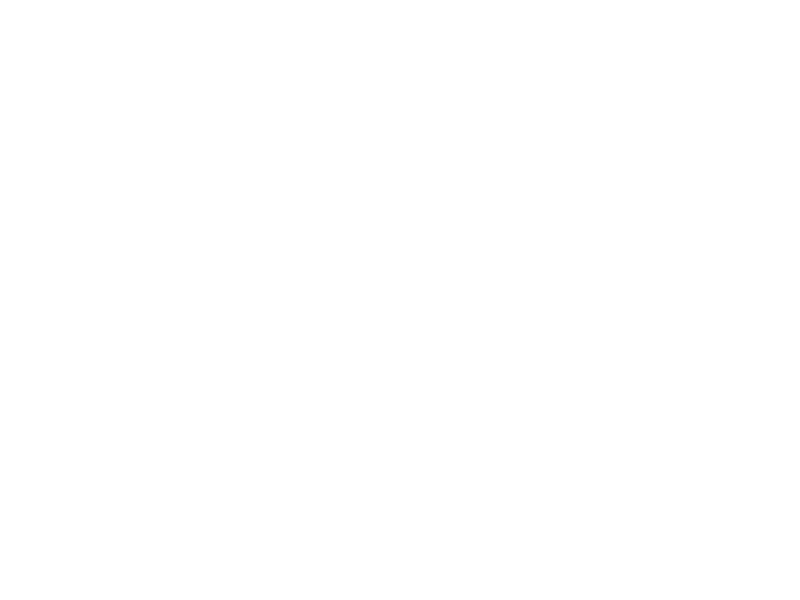

In [14]:
import numpy
from nutils import *

# define problem parameters
nelems  = 8
ischeme = 'gauss3'

# construct topology, geometry and basis
verts = numpy.linspace(-0.5**0.5, 0.5**0.5, nelems+1)
domain, geom = mesh.rectilinear([verts, verts])

# construct namespace
ns = function.Namespace()
ns.x = geom
ns.basis = domain.basis('spline', degree=1)

# construct matrix
A = domain.integrate(
    ns.eval_ij('basis_i,k basis_j,k'),
    geometry=geom, ischeme=ischeme)

x0, x1 = geom
ns.f = function.sin(x0) * function.exp(x1)

# construct dirichlet boundary constraints
cons = domain.boundary.project(
    ns.f, onto=ns.basis, geometry=geom, ischeme=ischeme)

# solve linear system
w = A.solve(constrain=cons)

# construct solution
u = ns.basis.dot(w)

# plot
points, colors = domain.elem_eval( [geom, u], ischeme='bezier3', separate=True)
plt = plot.PyPlot()
plt.mesh(points, colors)
plt.colorbar()


The statement

In [15]:
u = ns.basis.dot(w)

creates a solution function, the equivalent of $u=\varphi_iw_i$ where $\varphi_i$ is the basis.

The function `domain.elem_eval` evaluates Nutils functions specified via the first (positional) argument at several points on the topology and the function `plt.mesh` plots the results, where the first argument defines a position and the second a colour value.

## Laplace's equation with mixed BC's
We partially replace the Dirichlet boundary conditions with Neumann boundary conditions:

$$ \left\{ \begin{array}{ll} - u_{,kk} = 0 & \text{in } \Omega \\ u=f & \text{on } \Gamma_d \\ u_{,k}n_k = f_{,k}n_k & \text{on } \Gamma_n \end{array}\right. $$

with $\Gamma_d$ the left and bottom side of $\Omega$ and $\Gamma_n$ the top and right side of $\Omega$. Note that the solution to this problem is $u=f$, the same as for the problem with purely Dirichlet boundary conditions. A weak fomrulation of this system reads

> Find $w_j$ such that for all $i\in \{0,1,...,N-1\}$ for which $\varphi_i$ as *no* support on the boundary $\partial \Omega$ 
> $$ \int_\Omega \varphi_{i,k} \varphi_{j,k} w_j d\Omega=\int_{\Gamma_n} \varphi_i f_{,k}n_k d\Gamma $$ 
> and such that for all $i\in \{0,1,...,N-1\}$ for which $\varphi_i$ *has* support on the boundary $\partial \Omega$
> $$\int_{\partial \Omega}\varphi_i\left(\varphi_j w_j - f\right) d\Omega = 0.$$

Again, let $T$ be a structured partition of $8\times 8$ equally sized elements of $\Omega$ and $\varphi$ a linear basis on $T$. The following snippet shows the differences between the script for purely Dirichlet boundary conditions with the present case:

project > solve > solving system using sparse direct solver
project > constrained 17/81 dofs, error 9.90e-05/area
solve > solving system using sparse direct solver
elem_eval > created ndarray(576,2), ndarray(576)


<IPython.core.display.Javascript object>


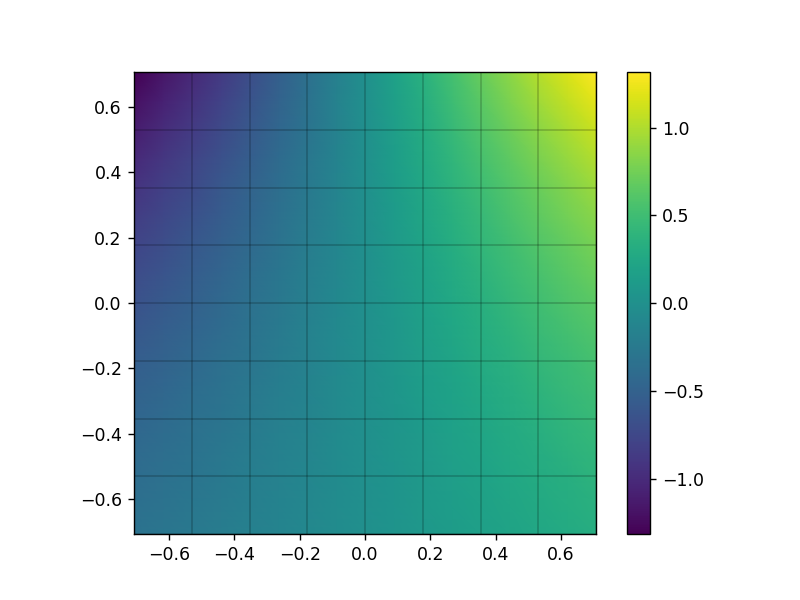

In [16]:
# construct dirichlet boundary constraints
cons = domain.boundary['left,bottom'].project(
    ns.f, onto=ns.basis, geometry=geom, ischeme='gauss3')

# construct right hand side
b = domain.boundary['right,top'].integrate(
    ns.eval_i('basis_i f_,k n_k'),
    geometry=geom, ischeme='gauss3')

# solve linear system
w = A.solve(b, constrain=cons)

# construct solution
u = ns.basis.dot(w)

# plot
points, colors = domain.elem_eval( [geom, u], ischeme='bezier3', separate=True)
plt = plot.PyPlot()
plt.mesh(points, colors)
plt.colorbar()

Since we are applying Dirichlet boundary conditions only on the left and bottom side of the domain, we have updated the projection of `f` as follows:


In [17]:
# construct dirichlet boundary constraints
cons = domain.boundary['left,bottom'].project(
    ns.f, onto=ns.basis, geometry=geom, ischeme='gauss3')

project > solve > solving system using sparse direct solver
project > constrained 17/81 dofs, error 9.90e-05/area


The expression `domain['left,bottom']` generates a subtopology of the boundary of `domain` limited to the left and bottom side.

The Neumann boundary condition, the left hand side of is implemented as follows:

In [18]:
# construct right hand side
b = domain.boundary['right,top'].integrate(
    ns.eval_i('basis_i f_,k n_k'),
    geometry=geom, ischeme='gauss3')

the expression string which is evaluated contains the keywords `basis` and `f` which we have specifically assigned to it, while the normal `n` is a special keyword that is always available.

## Circular geometry

So far we have been using square domains. The strict separation between topology and geometry might have looked unnecessarily complex. However, it allows us to generate a different geometry on a structured topology quite easily. For the sake of argument let's apply the same problem with mixed boundary conditions on a circular domain:

$$ \Omega_{\text{circ}} = \left\{x\in \mathbb{R}^2 : \| x\|_2^2<\frac{1}{2}\right\}.$$

We can create the mapping $g: \Omega \rightarrow \Omega_{\text{circ}}$ by

$$ g_i : x\mapsto \left\{ \begin{array}{ll} \sin(x_0) \cos(x_1) & \text{if } i=0 \\ \cos(x_0)\sin(x_1) & \text{if } i=1 \end{array} \right.$$
where $x_0,x_1\in [-\pi/4, \pi/4]$.

In the Nutils script the only difference with the previous script is the definitions of the geometry. We create a structured topology and geometry as before and redefine `geom` using 

In [19]:
from math import pi
# construct topology, geometry and basis
verts = numpy.linspace(-pi/4, pi/4, nelems+1)
domain, geom = mesh.rectilinear([verts, verts])

# construct a circular geometry
domain, geom = mesh.rectilinear([verts, verts])
geom = function.stack([
    function.sin(geom[0]) * function.cos(geom[1]),
    function.cos(geom[0]) * function.sin(geom[1]),
])

The rest of the script is unchanged

project > solve > solving system using sparse direct solver
project > constrained 32/81 dofs, error 1.13e-04/area
solve > solving system using sparse direct solver
elem_eval > created ndarray(576,2), ndarray(576)


<IPython.core.display.Javascript object>


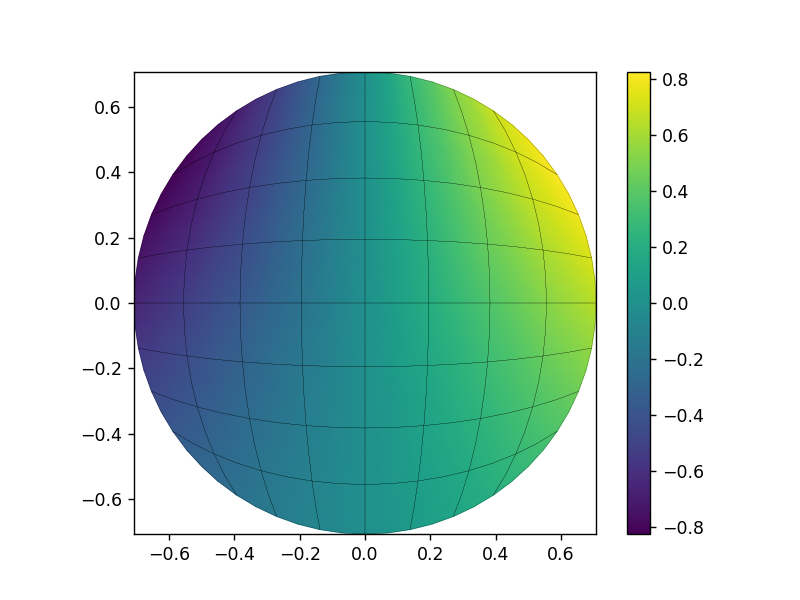

In [20]:
# construct integrand
ns = function.Namespace()
ns.x = geom
ns.basis = domain.basis('spline', degree=1)

# construct matrix
A = domain.integrate(
    ns.eval_ij('basis_i,k basis_j,k'),
    geometry=geom, ischeme='gauss3')

x0, x1 = geom
ns.f = function.sin(x0) * function.exp(x1)

# construct dirichlet boundary constraints
cons = domain.boundary.project(
    ns.f, onto=ns.basis, geometry=geom, ischeme='gauss3')

# solve linear system
w = A.solve(constrain=cons)

# construct solution
u = ns.basis.dot(w)

# plot
points, colors = domain.elem_eval( [geom, u], ischeme='bezier3', separate=True)
plt = plot.PyPlot()
plt.mesh(points, colors)
plt.colorbar()

## Unsteady heat equation

Next, we consider the unsteady [heat equation](https://en.wikipedia.org/wiki/Heat_equation) with homogeneous Dirichlet boundary conditions:

$$ \left\{ \begin{array}{ll} u_{,t} - \alpha u_{,kk} = 0 & \text{in } \Omega \\ u=0 & \text{on } \partial \Omega \\ u=\frac{1}{2}+\frac{1}{2}\tanh(cl) & \text{at } t=0 \end{array}\right. $$

with domain $\Omega=[0,1]^2$, $c$ a scalar and $l$ the following level set function:

$$ l(x) = \max\{l_1(x), l_2(x)\} $$

with

\begin{eqnarray}
    l_1(x) & = & 0.15 - (|0.3-x_0| + |0.4 - x_1|) \\
    l_2(x) & = & 0.15 - \sqrt{|0.7-x_0|^2 + |0.6-x_1|^2}
\end{eqnarray}

The level set function $l_1$ describes a square centred at $(0.3, 0.4)$ and function $l_2$ a circle with radius 0.15 centred at $(0.7,0.6)$. The hyperbolic tangent is used to generated a smoothed heaviside of the level set $l$, with smoothness controlled by parameter $c$.

A weak formulation of this system with the [Crank–Nicolson method](https://en.wikipedia.org/wiki/Crank%E2%80%93Nicolson_method) applied for the temporal part reads:

> Let the matrix $A$ be given by
> $$ A_{ij} = \int_\Omega \left( \frac{1} {\Delta t}\varphi_i \varphi_j + \frac{\alpha}{2}\varphi_{i,k} \varphi_{j,k}\right) d\Omega $$
> and $B$ by 
>  $$ A_{ij} = \int_\Omega \left( \frac{1} {\Delta t}\varphi_i \varphi_j - \frac{\alpha}{2}\varphi_{i,k} \varphi_{j,k}\right) d\Omega $$
> Given the solution at time step $n$, $2_j^{(n)}$, find $w_j^{(n+1)}$ such that for all $i\in \{0,1,...,N-1\}$ for which $\varphi_i$ has *no* support on the boundary $\partial \Omega$
> $$\int_{\partial\Omega} \varphi_i\left( \varphi_j w_j^{(n+1)}-0\right) d\Omega = 0$$

Note that matrices $A$ and $B$ do not depend on the time step $n$.

Let $T$ be a structured partiion of $64\times 64$ equatlly sized elements of $\Omega$ and $\varphi$ a second order basis on $T$. The following Nutils script implements the weak formulation and finds a solution from $t=0$ to $t=1$ in hundread steps:

In [21]:
import numpy
from nutils import *

# define problem parameters
alpha = 0.01
nelems = 20
degree = 2
dt = 0.05
tend = 1

# construct topology and geometry 
verts = numpy.linspace(0, 1, nelems+1)
domain, geom = mesh.rectilinear([verts, verts])

# construct namespace and basis
ns = function.Namespace()
ns.x = geom
ns.basis = domain.basis('spline', degree=degree)
ns.dt    = dt
ns.alpha = alpha

# construct matrices
A = domain.integrate(
    ns.eval_ij('(1 / dt) basis_i basis_j + (alpha / 2) basis_i,k basis_j,k'),
    geometry=geom, ischeme='gauss4')
B = domain.integrate(
    ns.eval_ij('(1 / dt) basis_i basis_j - (alpha / 2) basis_i,k basis_j,k'),
    geometry=geom, ischeme='gauss4')

# construct dirichlet boundary constraints
cons = domain.boundary.project(
    0, onto=ns.basis, geometry=geom, ischeme='gauss4')

# construct initial condition
x0, x1 = geom
l = function.max(
    # level set of a square centred at (0.3,0.4)
    0.15 - (abs(0.3 - x0) + abs(0.4 - x1)),
    # level set of a circle centred at (0.7,0.6)
    0.15 - ((0.7 - x0)**2 + (0.6 - x1)**2)**0.5,
)
# smooth heaviside of level set
u0 = 0.5 + 0.5*function.tanh(nelems/2*l)

U_all = []
for n in log.range('timestep', round(tend/dt) + 1):

    if n == 0:
        # project initial condition on `basis`
        w = domain.project(
            u0, onto=ns.basis, geometry=geom,
            ischeme='gauss4')
    else:
        # time step
        w = A.solve(B.matvec(w), constrain=cons)

    # construct solution
    u = ns.basis.dot(w)
    U_all.append(u)


project > constrained 84/484 dofs, error 0.00e+00/area
timestep 0 (0%) > project > solve > solving system using sparse direct solver
timestep 0 (0%) > project > constrained 484/484 dofs, error 7.00e-03/area
timestep 1 (5%) > solve > solving system using sparse direct solver
timestep 2 (10%) > solve > solving system using sparse direct solver
timestep 3 (14%) > solve > solving system using sparse direct solver
timestep 4 (19%) > solve > solving system using sparse direct solver
timestep 5 (24%) > solve > solving system using sparse direct solver
timestep 6 (29%) > solve > solving system using sparse direct solver
timestep 7 (33%) > solve > solving system using sparse direct solver
timestep 8 (38%) > solve > solving system using sparse direct solver
timestep 9 (43%) > solve > solving system using sparse direct solver
timestep 10 (48%) > solve > solving system using sparse direct solver
timestep 11 (52%) > solve > solving system using sparse direct solver
timestep 12 (57%) > solve > solvi

We may animate the solution

elem_eval > created ndarray(3600,2), ndarray(3600)


<IPython.core.display.Javascript object>


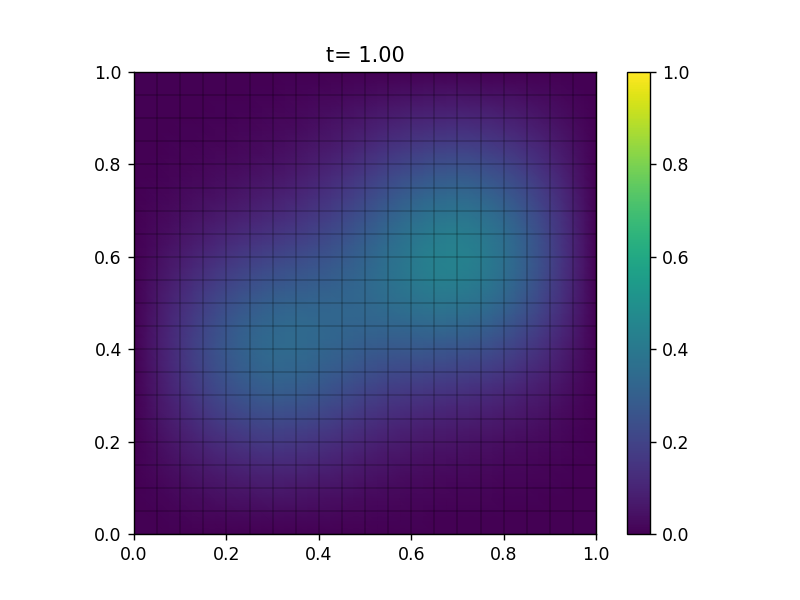

In [22]:
import matplotlib.animation as animation

# animate solution
points, colors = domain.elem_eval([geom, U_all[0]], ischeme='bezier3', separate=True)
plt = plot.PyPlot()
def animate(i):
    plt._fig.clear()
    points, colors = domain.elem_eval([geom, U_all[i]], ischeme='bezier3', separate=True)
    plt.mesh(points, colors)
    plt.colorbar()
    plt.clim(0, 1)
    plt.title('t={:5.2f}'.format(i*dt))

ani = animation.FuncAnimation(plt._fig, animate, numpy.arange(0,round(tend/dt)+1), interval=100, repeat=False)